In [1]:
import numpy as np
import pandas as pd

import keras
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train = pd.read_csv("gs://123test_bucket/train.csv")

#### Scaling by np.log1p

In [3]:
#train['meter_reading'] = np.log1p(train['meter_reading'])

#### Applying TimeseriesGenerator to the ASHRAE training data

Once difference between the example above, and our situation is that we have multiple timeseries, for each building and each meter in the building. So, we will be required to modify the code a little bit.

Below, we check how many meters exist in the dataset.

In [4]:
len(train[['building_id', 'meter']].drop_duplicates())

2380

The code below has been taken from this stackoverflow answer with some modifications:
https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459

The modification is basically that once we subset the data for building ID, it is then subset for meter type also.

Further reading about modifying keras generator classes can be found below:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [36]:
# https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459
# https://keras.io/preprocessing/sequence/
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dt, length = 168, batch_size = 10):
        self.tgs = list()
        for i in range(dt['building_id'].min(),dt['building_id'].max()+1):
            sub = dt.loc[dt['building_id'] == i, ['meter', 'meter_reading']]
            for meter in sub['meter'].unique():
                # subsetting sub for meter type
                adf = sub.loc[sub['meter'] == meter, 'meter_reading'].values
                adf = np.reshape(adf, (len(adf),1))
                self.tgs.append(TimeseriesGenerator(adf,adf,length,batch_size=batch_size))
        self.len = sum([len(tg) for tg in self.tgs])
        self.idx_i = list()
        self.idx_j = list()

        for i, tg in enumerate(self.tgs):
            self.idx_i.extend(list(range(len(tg))))
            self.idx_j.extend([i]*len(tg))    
        #print ( self.idx_i,  self.idx_j)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.tgs[self.idx_j[index]][self.idx_i[index]]



Based on a manual check it was found that there were 12 unique meters in the train_sub dataset.

In our case we want to use 24*7 timesteps, representing 7 days and 24 hours. We can experiment with the batch size but using 20 here for a short example.

#### Training and Validation Generators

Using 30% of the data as validation data. If more data is needed, we should consider adding data by randomly selecting buildings.

In [6]:
ids = train['building_id'].unique()

In [7]:
# keeping only 20% of the ids
len_sub = round(len(ids)*0.05)
ids_sub = np.random.choice(ids, len_sub, replace = False)

In [8]:
# 0.3 represents the percentage of data that is kept for validation
len_val = round(len(ids_sub)*0.3)

In [9]:
ids_val = np.random.choice(ids_sub, len_val, replace = False)

In [10]:
ids_train = np.setdiff1d(ids_sub,ids_val)

In [11]:
assert len(ids_val)+len(ids_train)==len(ids_sub)

In [37]:
# Test
length = 24*7
batch_size = 10
train_gen = DataGenerator(train[train['building_id'].isin(ids_train)],length, batch_size = batch_size)
val_gen = DataGenerator(train[train['building_id'].isin(ids_val)],length, batch_size = batch_size)
                                

### CNN-1D Model Creation

In [13]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Concatenate, Flatten, Reshape, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.utils import plot_model

from keras.datasets import imdb

Following the tutorial here:
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [14]:
# define the keras model
model = Sequential()
model.add(Dense(24, input_dim=168, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

In [15]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [16]:
# compile the keras model
model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mse', 'mae', 'mape'])

In [30]:
# Train model on dataset
model.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=5,
                    use_multiprocessing=True,
                    workers=24)


Epoch 1/5
76139/76139 [==============================] - 533s 7ms/step - loss: 40.5328 - mse: 31520.5371 - mae: 33.4721 - mape: 1030959936.0000 - val_loss: 59.9675 - val_mse: 56404.9297 - val_mae: 60.0602 - val_mape: 1450557568.0000
Epoch 2/5
Epoch 1/5
76139/76139 [==============================] - 548s 7ms/step - loss: 35.8421 - mse: 25299.3496 - mae: 28.7920 - mape: 832230720.0000 - val_loss: 412.8374 - val_mse: 53033.6016 - val_mae: 53.3504 - val_mape: 1472604160.0000
Epoch 3/5
76139/76139 [==============================] - 537s 7ms/step - loss: 34.4655 - mse: 23038.7520 - mae: 27.4263 - mape: 791838848.0000 - val_loss: 410.9258 - val_mse: 41930.7812 - val_mae: 49.2232 - val_mape: 1273587072.0000
Epoch 4/5
76139/76139 [==============================] - 522s 7ms/step - loss: 33.2928 - mse: 21630.6445 - mae: 26.2599 - mape: 710123136.0000 - val_loss: 256.0538 - val_mse: 41125.7695 - val_mae: 44.9790 - val_mape: 1149628544.0000
Epoch 5/5
76139/76139 [==============================] - 5

   10/76139 [..............................] - ETA: 2:38:47 - loss: 35.0894 - mse: 2248.2881 - mae: 30.4263 - mape: 3704736000.0000

In [17]:
X, Y = val_gen[0]

In [18]:
#Ynew = model.predict(X)

In [19]:
#Ynew = np.concatenate( Ynew, axis=0 )

In [20]:
#np.sqrt(np.mean(np.square(Ynew - Y)))

NameError: name 'Ynew' is not defined

In [21]:
np.shape(X)

(10, 168)

In [22]:
(batch_size,1,length)

(10, 1, 168)

#### CNN 1-D


In [23]:
#model = Sequential()
filters = 64
input_shape = Input(shape=(length,1))
#input_shape = Input(shape=(batch_size,1,length))
m1 = Conv1D(filters=filters, kernel_size=3, activation='relu')(input_shape)
print(m1.shape)
m1 = MaxPooling1D(pool_size=2, strides=2)(m1)
#m1 = Flatten()(m1)

m2 = Conv1D(filters=filters, kernel_size=5, activation='relu')(input_shape)
print(m2.shape)
m2 = MaxPooling1D(pool_size=2, strides=2)(m2)
#m2 = Flatten()(m2)

m3 = Conv1D(filters=filters, kernel_size=7, activation='relu')(input_shape)
print(m3.shape)
m3 = MaxPooling1D(pool_size=2, strides=2)(m3)
#m3 = Flatten()(m3)

m = keras.layers.concatenate([m1, m2, m3], axis = 1)
#m = Flatten()(m)

(None, 166, 64)
(None, 164, 64)
(None, 162, 64)


In [24]:
print(m1.shape)
print(m2.shape)
print(m3.shape)
print(m.shape)

(None, 83, 64)
(None, 82, 64)
(None, 81, 64)
(None, 246, 64)


In [25]:
#m = Reshape((246*filters, 1))(m)

In [26]:
m = LSTM(64, return_sequences=True)(m)
m = Lambda(lambda x: keras.backend.mean(x, axis=2))(m)

out = Dense(64, activation='relu')(m)
out = Dense(1, activation='relu')(out)

model = Model(input_shape, out)

In [27]:
print(m.shape)

(None, 246)


In [28]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])

In [29]:
out.shape

TensorShape([None, 1])

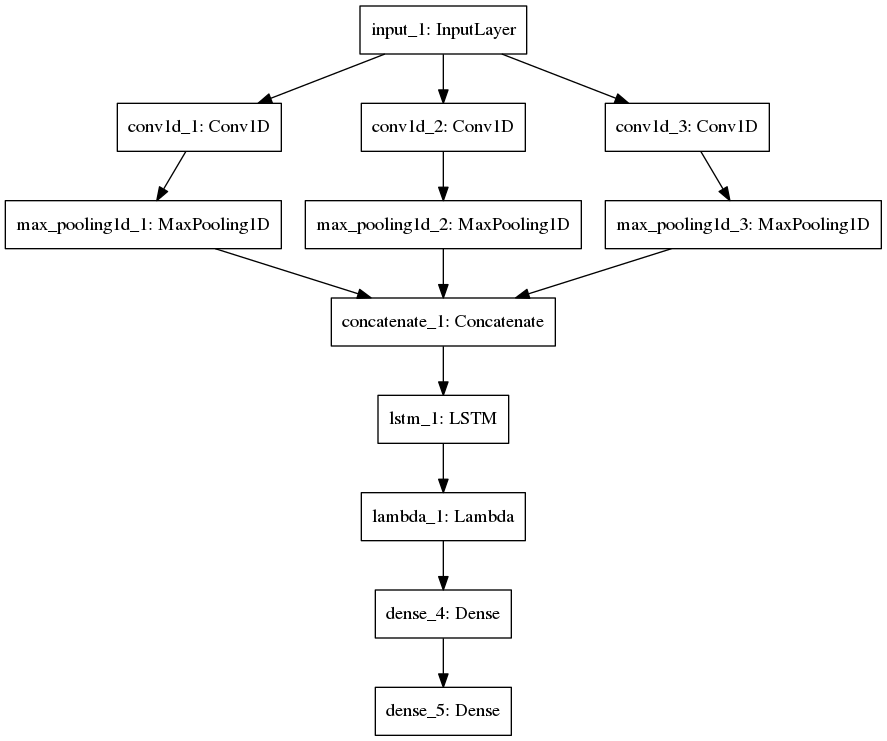

In [30]:
plot_model(model)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 166, 64)      256         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 164, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 162, 64)      512         input_1[0][0]                    
____________________________________________________________________________________________

In [32]:
X = np.random.randn(10, 168, 1)

In [35]:
model.fit(x=X, y=Y, batch_size=10)

Epoch 1/1
10/10 [==============================] - 6s 579ms/step - loss: 7.2575e-06 - mse: 7.2575e-06 - mae: 0.0014 - mape: 1393228.0000


In [34]:
# Train model on dataset
model.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=5,
                    use_multiprocessing=True,
                    workers=24)

Epoch 1/5



ValueError: Error when checking input: expected input_1 to have 3 dimensions, but got array with shape (10, 168)